In [111]:
from fastai.tabular.all import *

In [112]:
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100000)

# Зареждане на данните

In [113]:
dataset = pd.read_csv('../data/prepared-car-offers.csv')

In [114]:
dataset.sample(20)

,Make,Model,BodyType,FuelType,Transmission,EngineSize,Horsepower,EuroStandard,Mileage,MilesPerFullCharge (EV),BatteryCapacity (EV),Color,Price,Region,SafetyFeatures_GPS система за проследяване,SafetyFeatures_Автоматичен контрол на стабилността,SafetyFeatures_Адаптивни предни светлини,SafetyFeatures_Антиблокираща система,SafetyFeatures_Въздушни възглавници - Задни,SafetyFeatures_Въздушни възглавници - Предни,SafetyFeatures_Въздушни възглавници - Странични,SafetyFeatures_Ел. разпределяне на спирачното усилие,SafetyFeatures_Електронна програма за стабилизиране,SafetyFeatures_Контрол на налягането на гумите,SafetyFeatures_Парктроник,SafetyFeatures_Система ISOFIX,SafetyFeatures_Система за динамична устойчивост,SafetyFeatures_Система за защита от пробуксуване,SafetyFeatures_Система за изсушаване на накладките,SafetyFeatures_Система за контрол на дистанцията,SafetyFeatures_Система за контрол на спускането,SafetyFeatures_Система за подпомагане на спирането,ComfortFeatures_Auto Start Stop function,ComfortFeatures_Bluetooth \ handsfree система,ComfortFeatures_DVD,ComfortFeatures_IN\AUX изводи,ComfortFeatures_Steptronic,ComfortFeatures_TV,ComfortFeatures_Tiptronic,ComfortFeatures_USB,ComfortFeatures_audio\video,ComfortFeatures_Адаптивно въздушно окачване,ComfortFeatures_Безключово палене,ComfortFeatures_Блокаж на диференциала,ComfortFeatures_Бордкомпютър,ComfortFeatures_Бързи \ бавни скорости,ComfortFeatures_Датчик за светлина,ComfortFeatures_Ел. Огледала,ComfortFeatures_Ел. Стъкла,ComfortFeatures_Ел. регулиране на окачването,ComfortFeatures_Ел. регулиране на седалките,ComfortFeatures_Ел. усилвател на волана,ComfortFeatures_Климатик,ComfortFeatures_Климатроник,ComfortFeatures_Мултифункционален волан,ComfortFeatures_Навигация,ComfortFeatures_Отопление на волана,ComfortFeatures_Печка,ComfortFeatures_Подгряване на предното стъкло,ComfortFeatures_Подгряване на седалките,ComfortFeatures_Регулиране на волана,ComfortFeatures_Сензор за дъжд,ComfortFeatures_Серво усилвател на волана,ComfortFeatures_Система за измиване на фаровете,ComfortFeatures_Система за контрол на скоростта (автопилот),ComfortFeatures_Стерео уредба,ComfortFeatures_Термопомпа,ComfortFeatures_Хладилна жабка,OtherFeatures_4x4,OtherFeatures_7 места,OtherFeatures_Buy back,OtherFeatures_Бартер,OtherFeatures_Газова уредба,OtherFeatures_Дълга база,OtherFeatures_Капариран\Продаден,OtherFeatures_Катастрофирал,OtherFeatures_Къса база,OtherFeatures_Лизинг,OtherFeatures_Метанова уредба,OtherFeatures_На части,OtherFeatures_Напълно обслужен,OtherFeatures_Нов внос,OtherFeatures_С регистрация,OtherFeatures_Сервизна книжка,OtherFeatures_Тунинг,ExteriorFeatures_2(3) Врати,ExteriorFeatures_4(5) Врати,ExteriorFeatures_LED фарове,ExteriorFeatures_Ксенонови фарове,ExteriorFeatures_Лети джанти,ExteriorFeatures_Металик,ExteriorFeatures_Панорамен люк,ExteriorFeatures_Рейлинг на покрива,ExteriorFeatures_Спойлери,ExteriorFeatures_Теглич,ExteriorFeatures_Халогенни фарове,ExteriorFeatures_Шибедах,SecurityFeatures_OFFROAD пакет,SecurityFeatures_Аларма,SecurityFeatures_Брониран,SecurityFeatures_Каско,SecurityFeatures_Лебедка,SecurityFeatures_Централно заключване,InteriorFeatures_Велурен салон,InteriorFeatures_Десен волан,InteriorFeatures_Кожен салон,SpecialisedFeatures_TAXI,SpecialisedFeatures_За хора с увреждания,SpecialisedFeatures_Катафалка,SpecialisedFeatures_Линейка,SpecialisedFeatures_Учебен,SpecialisedFeatures_Хладилен,SpecialisedFeatures_Хомологация N1,Age,TotalSafetyFeatures,TotalComfortFeatures,TotalOtherFeatures,TotalExteriorFeatures,TotalSecurityFeatures,TotalInteriorFeatures,TotalSpecialisedFeatures
72805,Toyota,Urban Cruiser,Хечбек,Дизелов,Ръчна,NaN,90.00,Евро 4,99069.00,NaN,NaN,Графит,12500.00,Варна,0,0,0,1,1,1,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,1,1,1,0,0,0,0,1,1,0,0,0,0,0,1,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,15,6,16,4,4,2,0,0
58046,Peugeot,307,Кабрио,Бензинов,Ръчна,NaN,111.00,NaN,200000.00,NaN,NaN,Т.зелен,45

In [115]:
dataset = dataset.drop(columns='Region')

In [116]:
model_categories = dataset['Model'].unique()
dataset_no_model_outliers = dataset.copy()

for model in model_categories:
    iqr = dataset_no_model_outliers[dataset_no_model_outliers['Model'] == model]['Price'].quantile(0.75) - dataset_no_model_outliers[dataset_no_model_outliers['Model'] == model]['Price'].quantile(0.25)
    lower_bound = dataset_no_model_outliers[dataset_no_model_outliers['Model'] == model]['Price'].quantile(0.25) - 1.5 * iqr
    upper_bound = dataset_no_model_outliers[dataset_no_model_outliers['Model'] == model]['Price'].quantile(0.75) + 1.5 * iqr
    dataset_no_model_outliers = dataset_no_model_outliers[
        (dataset_no_model_outliers['Model'] != model) | 
        ((dataset_no_model_outliers['Model'] == model) & (dataset_no_model_outliers['Price'] >= lower_bound) & (dataset_no_model_outliers['Price'] <= upper_bound))
    ]
    
make_categories = dataset['Make'].unique()
dataset_no_make_model_outliers = dataset_no_model_outliers.copy()

for make in make_categories:
    iqr = dataset_no_model_outliers[dataset_no_model_outliers['Make'] == make]['Price'].quantile(0.75) - dataset_no_model_outliers[dataset_no_model_outliers['Make'] == make]['Price'].quantile(0.25)
    lower_bound = dataset_no_model_outliers[dataset_no_model_outliers['Make'] == make]['Price'].quantile(0.25) - 1.5 * iqr
    upper_bound = dataset_no_model_outliers[dataset_no_model_outliers['Make'] == make]['Price'].quantile(0.75) + 1.5 * iqr
    dataset_no_make_model_outliers = dataset_no_make_model_outliers[
        (dataset_no_make_model_outliers['Make'] != make) | 
        ((dataset_no_make_model_outliers['Make'] == make) & (dataset_no_make_model_outliers['Price'] >= lower_bound) & (dataset_no_make_model_outliers['Price'] <= upper_bound))
    ]
    
dataset_no_make_model_outliers.shape

(72787, 120)

In [117]:
dataset = dataset_no_make_model_outliers

# Попълване на липсващи числови стойности

In [118]:
dataset[dataset.select_dtypes(include=[np.float64]).columns] = dataset[dataset.select_dtypes(include=[np.float64]).columns].fillna(0)
dataset[dataset.select_dtypes(include=np.float64).columns] = dataset.select_dtypes(include=np.float64).astype(int)

# Конфигуриране на модела

In [119]:
splits = RandomSplitter(valid_pct=0.2)(range_of(dataset))

In [120]:
y_names = ['Price']
cat_names = dataset.select_dtypes(include=object).columns.to_list()
cont_names = dataset.drop(columns='Price').select_dtypes(include=np.number).columns.to_list()

cat_names, cont_names

(['Make',
  'Model',
  'BodyType',
  'FuelType',
  'Transmission',
  'EuroStandard',
  'Color'],
 ['EngineSize',
  'Horsepower',
  'Mileage',
  'MilesPerFullCharge (EV)',
  'BatteryCapacity (EV)',
  'SafetyFeatures_GPS система за проследяване',
  'SafetyFeatures_Автоматичен контрол на стабилността',
  'SafetyFeatures_Адаптивни предни светлини',
  'SafetyFeatures_Антиблокираща система',
  'SafetyFeatures_Въздушни възглавници - Задни',
  'SafetyFeatures_Въздушни възглавници - Предни',
  'SafetyFeatures_Въздушни възглавници - Странични',
  'SafetyFeatures_Ел. разпределяне на спирачното усилие',
  'SafetyFeatures_Електронна програма за стабилизиране',
  'SafetyFeatures_Контрол на налягането на гумите',
  'SafetyFeatures_Парктроник',
  'SafetyFeatures_Система ISOFIX',
  'SafetyFeatures_Система за динамична устойчивост',
  'SafetyFeatures_Система за защита от пробуксуване',
  'SafetyFeatures_Система за изсушаване на накладките',
  'SafetyFeatures_Система за контрол на дистанцията',
  'Safety

In [121]:
to = TabularPandas(dataset, procs=[Categorify, FillMissing], cat_names=cat_names, cont_names=cont_names, y_names=y_names, splits=splits)
dls = to.dataloaders(bs=1000)

In [122]:
dls.show_batch()

,Make,Model,BodyType,FuelType,Transmission,EuroStandard,Color,EngineSize,Horsepower,Mileage,MilesPerFullCharge (EV),BatteryCapacity (EV),SafetyFeatures_GPS система за проследяване,SafetyFeatures_Автоматичен контрол на стабилността,SafetyFeatures_Адаптивни предни светлини,SafetyFeatures_Антиблокираща система,SafetyFeatures_Въздушни възглавници - Задни,SafetyFeatures_Въздушни възглавници - Предни,SafetyFeatures_Въздушни възглавници - Странични,SafetyFeatures_Ел. разпределяне на спирачното усилие,SafetyFeatures_Електронна програма за стабилизиране,SafetyFeatures_Контрол на налягането на гумите,SafetyFeatures_Парктроник,SafetyFeatures_Система ISOFIX,SafetyFeatures_Система за динамична устойчивост,SafetyFeatures_Система за защита от пробуксуване,SafetyFeatures_Система за изсушаване на накладките,SafetyFeatures_Система за контрол на дистанцията,SafetyFeatures_Система за контрол на спускането,SafetyFeatures_Система за подпомагане на спирането,ComfortFeatures_Auto Start Stop function,ComfortFeatures_Bluetooth \ handsfree система,ComfortFeatures_DVD,ComfortFeatures_IN\AUX изводи,ComfortFeatures_Steptronic,ComfortFeatures_TV,ComfortFeatures_Tiptronic,ComfortFeatures_USB,ComfortFeatures_audio\video,ComfortFeatures_Адаптивно въздушно окачване,ComfortFeatures_Безключово палене,ComfortFeatures_Блокаж на диференциала,ComfortFeatures_Бордкомпютър,ComfortFeatures_Бързи \ бавни скорости,ComfortFeatures_Датчик за светлина,ComfortFeatures_Ел. Огледала,ComfortFeatures_Ел. Стъкла,ComfortFeatures_Ел. регулиране на окачването,ComfortFeatures_Ел. регулиране на седалките,ComfortFeatures_Ел. усилвател на волана,ComfortFeatures_Климатик,ComfortFeatures_Климатроник,ComfortFeatures_Мултифункционален волан,ComfortFeatures_Навигация,ComfortFeatures_Отопление на волана,ComfortFeatures_Печка,ComfortFeatures_Подгряване на предното стъкло,ComfortFeatures_Подгряване на седалките,ComfortFeatures_Регулиране на волана,ComfortFeatures_Сензор за дъжд,ComfortFeatures_Серво усилвател на волана,ComfortFeatures_Система за измиване на фаровете,ComfortFeatures_Система за контрол на скоростта (автопилот),ComfortFeatures_Стерео уредба,ComfortFeatures_Термопомпа,ComfortFeatures_Хладилна жабка,OtherFeatures_4x4,OtherFeatures_7 места,OtherFeatures_Buy back,OtherFeatures_Бартер,OtherFeatures_Газова уредба,OtherFeatures_Дълга база,OtherFeatures_Капариран\Продаден,OtherFeatures_Катастрофирал,OtherFeatures_Къса база,OtherFeatures_Лизинг,OtherFeatures_Метанова уредба,OtherFeatures_На части,OtherFeatures_Напълно обслужен,OtherFeatures_Нов внос,OtherFeatures_С регистрация,OtherFeatures_Сервизна книжка,OtherFeatures_Тунинг,ExteriorFeatures_2(3) Врати,ExteriorFeatures_4(5) Врати,ExteriorFeatures_LED фарове,ExteriorFeatures_Ксенонови фарове,ExteriorFeatures_Лети джанти,ExteriorFeatures_Металик,ExteriorFeatures_Панорамен люк,ExteriorFeatures_Рейлинг на покрива,ExteriorFeatures_Спойлери,ExteriorFeatures_Теглич,ExteriorFeatures_Халогенни фарове,ExteriorFeatures_Шибедах,SecurityFeatures_OFFROAD пакет,SecurityFeatures_Аларма,SecurityFeatures_Брониран,SecurityFeatures_Каско,SecurityFeatures_Лебедка,SecurityFeatures_Централно заключване,InteriorFeatures_Велурен салон,InteriorFeatures_Десен волан,InteriorFeatures_Кожен салон,SpecialisedFeatures_TAXI,SpecialisedFeatures_За хора с увреждания,SpecialisedFeatures_Катафалка,SpecialisedFeatures_Линейка,SpecialisedFeatures_Учебен,SpecialisedFeatures_Хладилен,SpecialisedFeatures_Хомологация N1,Age,TotalSafetyFeatures,TotalComfortFeatures,TotalOtherFeatures,TotalExteriorFeatures,TotalSecurityFeatures,TotalInteriorFeatures,TotalSpecialisedFeatures,Price
0,Honda,Accord,Седан,Бензинов,Автоматична,Евро 5,Черен,2400.00,201.00,150000.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,

In [123]:
learner = tabular_learner(dls, metrics=[rmse, mae], layers=[3000, 1000, 500, 250])

# Обучаване на модела

In [124]:
learner.fit(300, lr=0.002, cbs=[SaveModelCallback(fname='best-model', monitor='valid_loss')])

epoch,train_loss,valid_loss,_rmse,mae,time
0,1330795392.000000,1289492608.000000,35909.503906,22194.074219,00:00
1,1320548352.000000,1286236160.000000,35864.132812,22194.578125,00:00
2,1337740032.000000,1282608384.000000,35813.523438,22188.871094,00:00
3,1316072320.000000,1278509312.000000,35756.246094,22179.015625,00:00
4,1333221632.000000,1274913280.000000,35705.925781,22164.996094,00:00
5,1303699072.000000,1266622720.000000,35589.644531,22075.832031,00:00
6,1298311296.000000,1254234880.000000,35415.175781,22021.093750,00:00
7,1332309504.000000,1247256576.000000,35316.519531,21943.253906,00:00
8,1322364032.000000,1239252736.000000,35203.019531,21856.662109,00:00
9,1296799872.000000,1229356032.000000,35062.171875,21768.044922,00:00


Better model found at epoch 0 with valid_loss value: 1289492608.0.
Better model found at epoch 1 with valid_loss value: 1286236160.0.
Better model found at epoch 2 with valid_loss value: 1282608384.0.
Better model found at epoch 3 with valid_loss value: 1278509312.0.
Better model found at epoch 4 with valid_loss value: 1274913280.0.
Better model found at epoch 5 with valid_loss value: 1266622720.0.
Better model found at epoch 6 with valid_loss value: 1254234880.0.
Better model found at epoch 7 with valid_loss value: 1247256576.0.
Better model found at epoch 8 with valid_loss value: 1239252736.0.
Better model found at epoch 9 with valid_loss value: 1229356032.0.
Better model found at epoch 10 with valid_loss value: 1221986944.0.
Better model found at epoch 11 with valid_loss value: 1210652928.0.
Better model found at epoch 12 with valid_loss value: 1200234368.0.
Better model found at epoch 13 with valid_loss value: 1182068096.0.
Better model found at epoch 14 with valid_loss value: 1157

/Users/A1CD81D/python-venv/diploma/lib/python3.12/site-packages/fastai/learner.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=dev

In [125]:
learner.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : [CastToTensor]
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - before_step    : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback]
  End Epoch Loop

# Анализ на резултатите

In [126]:
preds = learner.get_preds(dl=learner.dls.test_dl(dataset))
data_with_preds = dataset.copy()
data_with_preds['Predicted Price'] = preds[0].numpy()

In [127]:
data_with_preds.sample(20)

,Make,Model,BodyType,FuelType,Transmission,EngineSize,Horsepower,EuroStandard,Mileage,MilesPerFullCharge (EV),BatteryCapacity (EV),Color,Price,SafetyFeatures_GPS система за проследяване,SafetyFeatures_Автоматичен контрол на стабилността,SafetyFeatures_Адаптивни предни светлини,SafetyFeatures_Антиблокираща система,SafetyFeatures_Въздушни възглавници - Задни,SafetyFeatures_Въздушни възглавници - Предни,SafetyFeatures_Въздушни възглавници - Странични,SafetyFeatures_Ел. разпределяне на спирачното усилие,SafetyFeatures_Електронна програма за стабилизиране,SafetyFeatures_Контрол на налягането на гумите,SafetyFeatures_Парктроник,SafetyFeatures_Система ISOFIX,SafetyFeatures_Система за динамична устойчивост,SafetyFeatures_Система за защита от пробуксуване,SafetyFeatures_Система за изсушаване на накладките,SafetyFeatures_Система за контрол на дистанцията,SafetyFeatures_Система за контрол на спускането,SafetyFeatures_Система за подпомагане на спирането,ComfortFeatures_Auto Start Stop function,ComfortFeatures_Bluetooth \ handsfree система,ComfortFeatures_DVD,ComfortFeatures_IN\AUX изводи,ComfortFeatures_Steptronic,ComfortFeatures_TV,ComfortFeatures_Tiptronic,ComfortFeatures_USB,ComfortFeatures_audio\video,ComfortFeatures_Адаптивно въздушно окачване,ComfortFeatures_Безключово палене,ComfortFeatures_Блокаж на диференциала,ComfortFeatures_Бордкомпютър,ComfortFeatures_Бързи \ бавни скорости,ComfortFeatures_Датчик за светлина,ComfortFeatures_Ел. Огледала,ComfortFeatures_Ел. Стъкла,ComfortFeatures_Ел. регулиране на окачването,ComfortFeatures_Ел. регулиране на седалките,ComfortFeatures_Ел. усилвател на волана,ComfortFeatures_Климатик,ComfortFeatures_Климатроник,ComfortFeatures_Мултифункционален волан,ComfortFeatures_Навигация,ComfortFeatures_Отопление на волана,ComfortFeatures_Печка,ComfortFeatures_Подгряване на предното стъкло,ComfortFeatures_Подгряване на седалките,ComfortFeatures_Регулиране на волана,ComfortFeatures_Сензор за дъжд,ComfortFeatures_Серво усилвател на волана,ComfortFeatures_Система за измиване на фаровете,ComfortFeatures_Система за контрол на скоростта (автопилот),ComfortFeatures_Стерео уредба,ComfortFeatures_Термопомпа,ComfortFeatures_Хладилна жабка,OtherFeatures_4x4,OtherFeatures_7 места,OtherFeatures_Buy back,OtherFeatures_Бартер,OtherFeatures_Газова уредба,OtherFeatures_Дълга база,OtherFeatures_Капариран\Продаден,OtherFeatures_Катастрофирал,OtherFeatures_Къса база,OtherFeatures_Лизинг,OtherFeatures_Метанова уредба,OtherFeatures_На части,OtherFeatures_Напълно обслужен,OtherFeatures_Нов внос,OtherFeatures_С регистрация,OtherFeatures_Сервизна книжка,OtherFeatures_Тунинг,ExteriorFeatures_2(3) Врати,ExteriorFeatures_4(5) Врати,ExteriorFeatures_LED фарове,ExteriorFeatures_Ксенонови фарове,ExteriorFeatures_Лети джанти,ExteriorFeatures_Металик,ExteriorFeatures_Панорамен люк,ExteriorFeatures_Рейлинг на покрива,ExteriorFeatures_Спойлери,ExteriorFeatures_Теглич,ExteriorFeatures_Халогенни фарове,ExteriorFeatures_Шибедах,SecurityFeatures_OFFROAD пакет,SecurityFeatures_Аларма,SecurityFeatures_Брониран,SecurityFeatures_Каско,SecurityFeatures_Лебедка,SecurityFeatures_Централно заключване,InteriorFeatures_Велурен салон,InteriorFeatures_Десен волан,InteriorFeatures_Кожен салон,SpecialisedFeatures_TAXI,SpecialisedFeatures_За хора с увреждания,SpecialisedFeatures_Катафалка,SpecialisedFeatures_Линейка,SpecialisedFeatures_Учебен,SpecialisedFeatures_Хладилен,SpecialisedFeatures_Хомологация N1,Age,TotalSafetyFeatures,TotalComfortFeatures,TotalOtherFeatures,TotalExteriorFeatures,TotalSecurityFeatures,TotalInteriorFeatures,TotalSpecialisedFeatures,Predicted Price
6433,Audi,Q2,Джип,Дизелов,Автоматична,0,115,Евро 6,108000,0,0,Тъмно син мет.,38555,0,0,1,1,1,1,1,0,1,1,1,1,0,1,0,0,0,1,1,1,0,1,1,0,1,1,1,0,0,0,1,0,1,1,1,0,0,0,0,1,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,1,1,1,1,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,6,11,20,4,7,2,1,0,37370.65
60423,Porsche,Cayenne,Джип,Бензинов,Автоматична,2900,441,Евро 6,56000,0,0,Бял,129000,1

In [128]:
errors_df = data_with_preds.copy()
errors = pd.Series(np.abs(data_with_preds['Price'] - data_with_preds['Predicted Price']))
errors_df['Error'] = errors

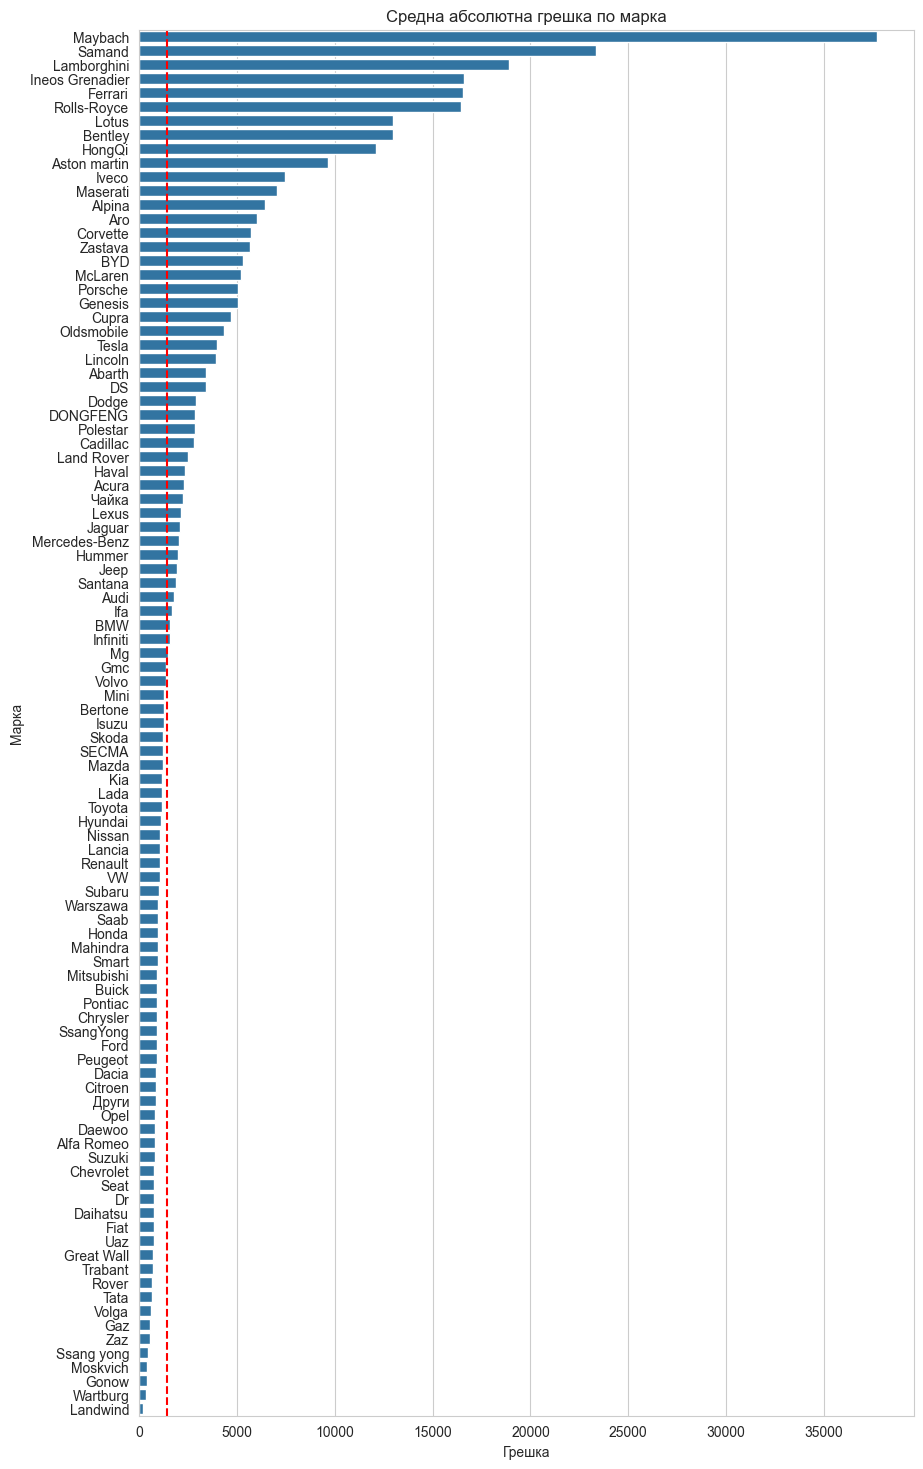

In [129]:
import seaborn as sns

# Group by 'Make' and calculate the mean error
mean_error_by_make = errors_df.groupby('Make')['Error'].mean().reset_index()

plt.figure(figsize=(10, 18))
ax = sns.barplot(x='Error', y='Make', data=mean_error_by_make.sort_values(by='Error', ascending=False), orient='h')
ax.axvline(errors_df['Error'].mean(), color='red', linestyle='--')
plt.title('Средна абсолютна грешка по марка')
plt.ylabel('Марка')
plt.xlabel('Грешка')
plt.show()

In [130]:
errors_df['Error value % of target'] = errors_df['Error'] / errors_df['Price'] * 100

print(f'Mean error value % of target {errors_df['Error value % of target'].mean()}')

errors_df.groupby('Make')['Error value % of target'].mean().sort_values(ascending=False)

Mean error value % of target 10.140308208378856


Make
Samand            440.66
Aro               151.24
Oldsmobile         56.35
Zastava            55.09
Iveco              38.37
Daewoo             37.77
Rover              28.04
Lada               23.38
Saab               23.05
Maybach            21.26
Lancia             21.22
Moskvich           19.48
Bertone            17.05
Volga              16.76
Alfa Romeo         16.64
Daihatsu           15.04
Ssang yong         14.58
Fiat               14.16
Chrysler           13.53
Citroen            13.42
Cadillac           13.39
Renault            13.23
Opel               13.12
Seat               12.88
Ford               12.68
Dr                 12.64
Smart              12.55
Tata               12.32
Mg                 12.28
Peugeot            11.98
Chevrolet          11.92
Warszawa           11.89
SsangYong          11.88
Ineos Grenadier    11.70
BYD                11.54
VW                 11.46
Mazda              11.41
Mini               10.79
Uaz                10.76
Lincoln            1

Text(0.5, 0, 'Грешка в % от цената')

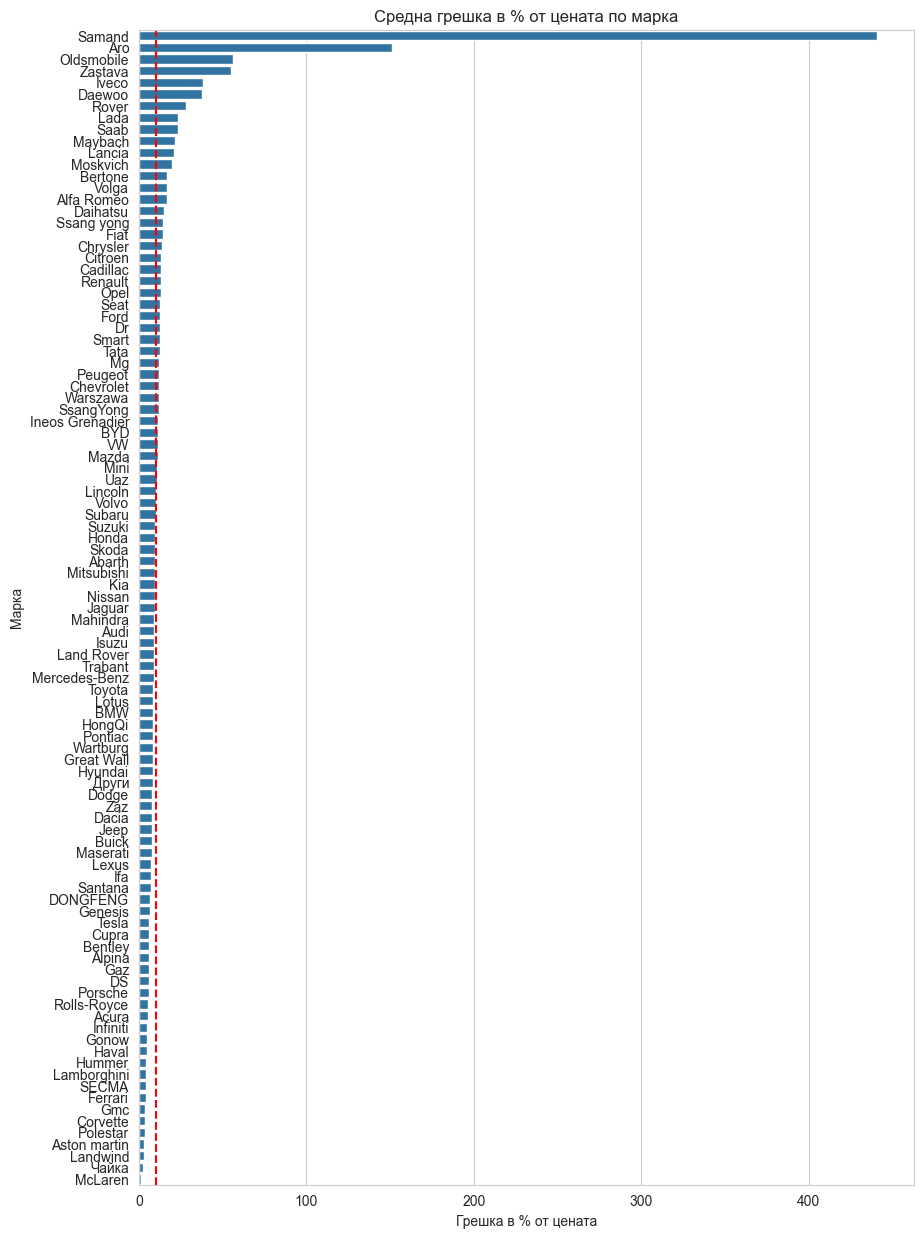

In [131]:
plt.figure(figsize=(10, 15))

ax = sns.barplot(x='Error value % of target', y='Make', data=errors_df.groupby('Make')['Error value % of target'].mean().reset_index().sort_values(by='Error value % of target', ascending=False), orient='h')
ax.axvline(errors_df['Error value % of target'].mean(), color='red', linestyle='--')
plt.title('Средна грешка в % от цената по марка')
plt.ylabel('Марка')
plt.xlabel('Грешка в % от цената')

# Експортиране на модела

In [132]:
learner.export(fname='../models/nn-car-price-model.pkl')